In [30]:
# Imports
import pandas as pd
import numpy as np
import doubleml as dml
from doubleml.datasets import fetch_401K

import torch
import os
import time
from functools import partial

# Causal_cocycle imports
from causal_cocycle.kernels_new import GaussianKernel
from causal_cocycle.distribution_estimation import ConditionalExpectationRegressor
from causal_cocycle.regression_functionals import NWFunctional
from causal_cocycle.conditioners_new import NWConditioner  # NWConditioner defined earlier
from causal_cocycle.transformers_new import KREpsLayer  # Your KR transformer layer
from causal_cocycle.model_factory import CocycleFactory
from causal_cocycle.loss_factory import CocycleLossFactory
from causal_cocycle.optimise_new import validate, optimise
from causal_cocycle.kernels import gaussian_kernel
from causal_cocycle.kernels_new import GaussianKernel

from e401k_cocycle_config import model_config, opt_config

In [2]:
# Getting data and names
Data = fetch_401K(return_type='DataFrame')
data = Data.to_numpy()
names = np.array(list(Data[:0]))

In [3]:
# Data set-up (outside wrapper function)

# Names
covariates = ['age', 'inc', 'educ', 'fsize', 'marr',
                 'twoearn', 'db', 'pira', 'hown', 'e401']
treatment = ["e401"]
outcome = ["net_tfa"]

# Creating tensors
X = Data[Data.columns.intersection(covariates)]
names_x = np.array(list(X[:0]))
treatment_ind = np.where(names_x == "e401")[0][0]
X = X.to_numpy()
cols_order = ([treatment_ind]+
              list(np.linspace(0,treatment_ind-1,treatment_ind).astype(int))+
              list(np.linspace(treatment_ind+1,len(X.T)-1,len(X.T)-1-treatment_ind).astype(int)))
X = X[:,cols_order]
N = len(X)
D = len(X.T)
Y = Data[Data.columns.intersection(outcome)].to_numpy().reshape(N,)
X,Y = torch.tensor(X),torch.tensor(Y).view(N,1)
print("# treated = ", int(X[:,0].sum()), "/", N)

# Scaling data
scale_X = torch.ones(len(X.T))
for i in range(len(X.T)):
    if len(torch.unique(X[:,i])) > 2:
        scale_X[i] = X[:,i].var(0)**0.5
scale_Y = Y.var(0)**0.5
Xscale,Yscale = X/scale_X, Y/scale_Y

# Random dataset shuffle
id = torch.randperm(Xscale.size(0))
Xtr,Ytr = Xscale[id],Yscale[id]

# treated =  3682 / 9915


In [4]:
Xtr.mean(0), Ytr.mean()

(tensor([0.3714, 3.9693, 1.5016, 1.8622, 4.6991, 0.2710, 0.6048, 0.3808, 0.2422,
         0.6352]),
 tensor(0.2842))

In [9]:
# Cocycle model construction
input_dim = D
factory = CocycleFactory(input_dim, model_config)
models, hyper_args = factory.build_models()
print(f"Constructed {len(models)} candidate models.")

Constructed 3 candidate models.


In [6]:
# Cocycle model construction
input_dim = D-1
factory = CocycleFactory(input_dim, model_config)
models, hyper_args = factory.build_models()
print(f"Constructed {len(models)} candidate models.")

# T estimator construction
import copy
from causal_cocycle.conditioners_new import AggregateConditioner, CompositeConditioner

for model in models:
    old_composite = model.conditioner
    assert isinstance(old_composite, CompositeConditioner)

    new_layers = []
    for layer in old_composite.layers:
        cond1 = copy.deepcopy(layer)
        cond2 = copy.deepcopy(layer)
        agg = AggregateConditioner([cond1, cond2])  # default keys are fine: "D", "X"
        new_layers.append(agg)

    # Replace with a new composite made of aggregate layers
    model.conditioner = CompositeConditioner(new_layers)

Constructed 3 candidate models.


In [10]:
# Cocycle loss construction
kernel = [gaussian_kernel()] * 2
loss_factory = CocycleLossFactory(kernel)
loss= loss_factory.build_loss("CMMD_V", Ytr, Ytr, subsamples=10**4)

In [11]:
# 1. Best overall model (choose one candidate based on average CV loss, then retrain on full training set)
#if not isinstance(Xtr,dict):
#    Xtr = {'X' : Xtr[:,1:],
#           'D' : Xtr[:,0].int()
#          }
    
final_model_overall, val_loss_overall = validate(
    models, 
    loss, 
    Xtr, Ytr,
    loss_val=loss,
    method="fixed",
    train_val_split=0.8,  # 2-fold CV: 50% training per fold.
    opt_kwargs=opt_config,
    hyper_kwargs=hyper_args,
    choose_best_model="overall",
    retrain=True
)
print(f"Best overall model validation loss: {val_loss_overall:.4f}")

Epoch 1/100, Training Loss: -0.4795
Epoch 2/100, Training Loss: -0.4811
Epoch 3/100, Training Loss: -0.4884
Epoch 4/100, Training Loss: -0.4922
Epoch 5/100, Training Loss: -0.4851
Epoch 6/100, Training Loss: -0.4926
Epoch 7/100, Training Loss: -0.4811
Epoch 8/100, Training Loss: -0.4778
Epoch 9/100, Training Loss: -0.4878
Epoch 10/100, Training Loss: -0.4876
Epoch 11/100, Training Loss: -0.4926
Epoch 12/100, Training Loss: -0.4926
Epoch 13/100, Training Loss: -0.4946
Epoch 14/100, Training Loss: -0.4837
Epoch 15/100, Training Loss: -0.4916
Epoch 16/100, Training Loss: -0.4901
Epoch 17/100, Training Loss: -0.4963
Epoch 18/100, Training Loss: -0.4898
Epoch 19/100, Training Loss: -0.4963
Epoch 20/100, Training Loss: -0.4838
Epoch 21/100, Training Loss: -0.4889
Epoch 22/100, Training Loss: -0.4929
Epoch 23/100, Training Loss: -0.4921
Epoch 24/100, Training Loss: -0.5007
Epoch 25/100, Training Loss: -0.5023
Epoch 26/100, Training Loss: -0.4979
Epoch 27/100, Training Loss: -0.4860
Epoch 28/1

In [12]:
# 3. Best overall model per treatment value (choose one candidate based on average CV loss, then retrain on full training set)
Xtr0, Ytr0 = Xtr[Xtr[:,0]==0], Ytr[Xtr[:,0]==0]
Xtr1, Ytr1 = Xtr[Xtr[:,0]==1], Ytr[Xtr[:,0]==1]
final_model_overall0, val_loss_overall0 = validate(
    models, 
    loss, 
    Xtr0, Ytr0,
    loss_val=loss,
    method="fixed",
    train_val_split=0.8,  # 2-fold CV: 50% training per fold.
    opt_kwargs=opt_config,
    hyper_kwargs=hyper_args,
    choose_best_model="overall",
    retrain=True
)
print(f"Best overall model (D=0) validation loss: {val_loss_overall:.4f}")

opt_config['val_batch_size'] = 512
final_model_overall1, val_loss_overall1 = validate(
    models, 
    loss, 
    Xtr1, Ytr1,
    loss_val=loss,
    method="fixed",
    train_val_split=0.8,  # 2-fold CV: 50% training per fold.
    opt_kwargs=opt_config,
    hyper_kwargs=hyper_args,
    choose_best_model="overall",
    retrain=True
)
print(f"Best overall model (D=1) validation loss: {val_loss_overall:.4f}")

Epoch 1/100, Training Loss: -0.5800
Epoch 2/100, Training Loss: -0.5765
Epoch 3/100, Training Loss: -0.5922
Epoch 4/100, Training Loss: -0.5816
Epoch 5/100, Training Loss: -0.5782
Epoch 6/100, Training Loss: -0.6022
Epoch 7/100, Training Loss: -0.5919
Epoch 8/100, Training Loss: -0.6056
Epoch 9/100, Training Loss: -0.5832
Epoch 10/100, Training Loss: -0.6069
Epoch 11/100, Training Loss: -0.5939
Epoch 12/100, Training Loss: -0.5918
Epoch 13/100, Training Loss: -0.6053
Epoch 14/100, Training Loss: -0.5857
Epoch 15/100, Training Loss: -0.5954
Epoch 16/100, Training Loss: -0.5883
Epoch 17/100, Training Loss: -0.5970
Epoch 18/100, Training Loss: -0.5884
Epoch 19/100, Training Loss: -0.5925
Epoch 20/100, Training Loss: -0.5963
Epoch 21/100, Training Loss: -0.5939
Epoch 22/100, Training Loss: -0.5908
Epoch 23/100, Training Loss: -0.5861
Epoch 24/100, Training Loss: -0.5935
Epoch 25/100, Training Loss: -0.6095
Epoch 26/100, Training Loss: -0.6025
Epoch 27/100, Training Loss: -0.5915
Epoch 28/1

In [13]:
# Modified KR transport (1D) with provided weights
def build_KR_map(X: torch.Tensor, Y: torch.Tensor, 
                                                   w_src: torch.Tensor = None, w_tgt: torch.Tensor = None, epsilon: float = 1e-8):

    # Get weights if not provided
    if w_src is None:
        n_src = X.numel()
        w_src = torch.ones(n_src, device=X.device) / n_src
    if w_tgt is None:
        n_tgt = Y.numel()
        w_tgt = torch.ones(n_tgt, device=Y.device) / n_tgt
    
    # Sort X and Y first
    X_sorted_full, idx_X = torch.sort(X)
    Y_sorted_full, idx_Y = torch.sort(Y)
    w_src_sorted_full = w_src[idx_X]
    w_tgt_sorted_full = w_tgt[idx_Y]
    
    # Get unique sorted values for X, and sum the weights of duplicates.
    X_sorted, inverse_idx_X = torch.unique(X_sorted_full, sorted=True, return_inverse=True)
    w_src_sorted = torch.zeros_like(X_sorted, dtype=w_src.dtype)
    w_src_sorted = w_src_sorted.scatter_add_(0, inverse_idx_X, w_src_sorted_full)
    
    # Do the same for Y.
    Y_sorted, inverse_idx_Y = torch.unique(Y_sorted_full, sorted=True, return_inverse=True)
    w_tgt_sorted = torch.zeros_like(Y_sorted, dtype=w_tgt.dtype)
    w_tgt_sorted = w_tgt_sorted.scatter_add_(0, inverse_idx_Y, w_tgt_sorted_full)
    
    # Normalize the weights.
    w_src_sorted = w_src_sorted / w_src_sorted.sum()
    w_tgt_sorted = w_tgt_sorted / w_tgt_sorted.sum()
    
    def S(z):
        z = z.double()
        if epsilon == 0:
            return (z>=0).float()
        else:
            return torch.where(z < -epsilon, torch.zeros_like(z),
                               torch.where(z > epsilon, torch.ones_like(z),
                                           (z + epsilon) / (2 * epsilon)))
    def F_src(y):
        if not isinstance(y, torch.Tensor):
            y = torch.tensor(y, device=X_sorted.device)
        if y.dim() == 0:
            y = y.unsqueeze(0)
        if y.dim() == 1:
            y = y.unsqueeze(1)
        X_exp = X_sorted.unsqueeze(0)
        S_vals = S(y - X_exp)
        return torch.sum(w_src_sorted * S_vals, dim=-1)
        
    def Q_tgt(t):
        if not isinstance(t, torch.Tensor):
            t = torch.tensor(t, device=Y_sorted.device)
        if t.dim() > 1:
            t = t.squeeze(-1)
        cumsum = torch.cumsum(w_tgt_sorted, dim=0)
        indices = torch.searchsorted(cumsum, t.unsqueeze(1)).squeeze(1)
        indices = torch.clamp(indices, 0, Y_sorted.numel()-1)
        j = indices-1
        j_next = indices
        cumsum = torch.concatenate((torch.zeros(1),cumsum))
        cumsum_j = cumsum[j+1]
        w_j_next = w_tgt_sorted[j_next]
        s = (t - cumsum_j) / w_j_next
        Y_j_next = Y_sorted[j_next].double()
        Y_prev = Y_sorted[torch.clamp(j, min=0)].double()
        return Y_j_next - epsilon + 2 * epsilon * s
        
    def KR(y):
        t_val = F_src(y)
        return Q_tgt(t_val)
    return KR

In [15]:
# Getting Y0scale, Y1scale using S estimator
X0scale,X1scale = Xscale*1,Xscale*1
X0scale[:,0] = 0
X1scale[:,0] = 1
Y0scale = final_model_overall.cocycle(X0scale,Xscale,Yscale).detach()
Y1scale = final_model_overall.cocycle(X1scale,Xscale,Yscale).detach()

In [16]:
# Getting Y0scale, Y1scale using T estimator
Xscale_0, Yscale_0 = Xscale[Xscale[:,0]==0],Yscale[Xscale[:,0]==0]
Xscale_1, Yscale_1 = Xscale[Xscale[:,0]==1],Yscale[Xscale[:,0]==1]
Uscale0 = final_model_overall0.inverse_transformation(Xscale_0,Yscale_0).detach()
Uscale1 = final_model_overall1.inverse_transformation(Xscale_1,Yscale_1).detach()
KR01 = build_KR_map(Uscale0[:,0].double(), Uscale1[:,0].double())
KR10 = build_KR_map(Uscale1[:,0].double(), Uscale0[:,0].double())
X1scale_0, X0scale_1 = Xscale_0, Xscale_1
X1scale_0[:,0],X0scale_1[:,0] = 1,0
Y1scale_0 = final_model_overall1.transformation(X1scale_0, KR01(Uscale0)[:,None])
Y0scale_1 = final_model_overall0.transformation(X0scale_1, KR10(Uscale1)[:,None])

In [17]:
(Y1scale-Y0scale).mean()*scale_Y,(Y1scale[Xscale[:,0]==1]-Y0scale[Xscale[:,0]==1]).mean()*scale_Y

(tensor([8918.9229]), tensor([11551.9453]))

In [18]:
(torch.concatenate((Y1scale_0, Yscale_1))-torch.concatenate((Yscale_0, Y0scale_1))).mean()*scale_Y,(Yscale_1-Y0scale_1).mean()*scale_Y

(tensor([10051.7725], grad_fn=<MulBackward0>),
 tensor([12540.0342], grad_fn=<MulBackward0>))

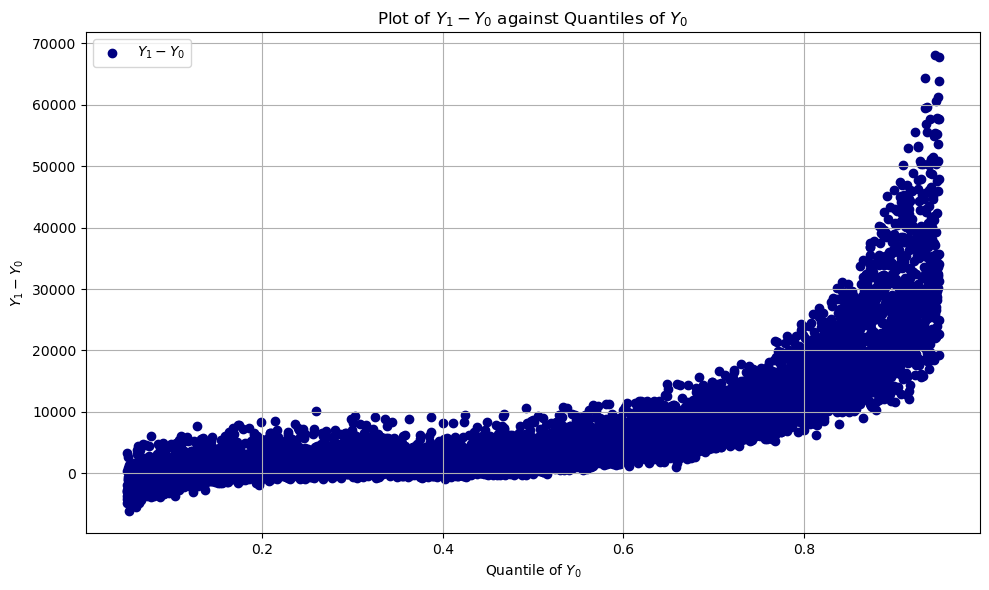

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Assume Y0scale and Y1scale are 1D numpy arrays of equal length
Y_diff = (Y1scale - Y0scale)

# Step 1: Sort Y0scale and get corresponding sorted Y_diff
sort_idx = np.argsort(Y0scale.squeeze(-1))
Y0_sorted = Y0scale[sort_idx]
Y_diff_sorted = Y_diff[sort_idx]

# Step 2: Compute quantile positions (from 0 to 1)
n = len(Y0scale)
quantile_positions = np.linspace(0, 1, n)

# Step 3: Plot
plt.figure(figsize=(10, 6))
l = int(n/20)
plt.scatter(quantile_positions[l:n-l], Y_diff_sorted[l:n-l]*scale_Y, label="$Y_1 - Y_0$", color='navy')
plt.xlabel("Quantile of $Y_0$")
plt.ylabel("$Y_1 - Y_0$")
plt.title("Plot of $Y_1 - Y_0$ against Quantiles of $Y_0$")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [67]:
# Train NW functional for 
kernel_ = GaussianKernel(lengthscale=torch.ones(1))
functional_ = NWFunctional(kernel=kernel_, reg=0.0)
CER_ = ConditionalExpectationRegressor(functional_)
print("Starting hyperparameter optimisation...")
test_points_ = torch.quantile(Y1scale - Y0scale, torch.linspace(0,1,100))
feature_ = ((Y1scale - Y0scale)<= test_points_.unsqueeze(0)).float()
losses = CER_.optimise(Y0scale, feature_, maxiter=1000, nfold=5, learn_rate=1e-1, print_=True, subsamples = 256)

Starting hyperparameter optimisation...
[iter 0] avg CV loss: 0.150921
lengthscale: tensor([0.9048], grad_fn=<ExpBackward0>)
[iter 10] avg CV loss: 0.120342
lengthscale: tensor([0.3275], grad_fn=<ExpBackward0>)
[iter 20] avg CV loss: 0.088956
lengthscale: tensor([0.1163], grad_fn=<ExpBackward0>)
[iter 30] avg CV loss: 0.069906
lengthscale: tensor([0.0464], grad_fn=<ExpBackward0>)
[iter 40] avg CV loss: 0.064577
lengthscale: tensor([0.0260], grad_fn=<ExpBackward0>)
[iter 50] avg CV loss: 0.065236
lengthscale: tensor([0.0207], grad_fn=<ExpBackward0>)
[iter 60] avg CV loss: 0.063831
lengthscale: tensor([0.0199], grad_fn=<ExpBackward0>)
[iter 70] avg CV loss: 0.064094
lengthscale: tensor([0.0206], grad_fn=<ExpBackward0>)
[iter 80] avg CV loss: 0.066786
lengthscale: tensor([0.0224], grad_fn=<ExpBackward0>)
[iter 90] avg CV loss: 0.064849
lengthscale: tensor([0.0240], grad_fn=<ExpBackward0>)
[iter 100] avg CV loss: 0.064646
lengthscale: tensor([0.0243], grad_fn=<ExpBackward0>)
[iter 110] avg

In [68]:
# defining cocycle model
diff_sorted,ids = (Y1scale-Y0scale).squeeze(-1).sort()
Y0sorted = Y0scale[ids]
conditioner_ = NWConditioner(Y0sorted, kernel_)
transformer_ = KREpsLayer(diff_sorted, epsilon = 0)

In [69]:
# Getting predictions
ntest = 50
Y0test = Y0scale.quantile(torch.linspace(0.1,0.9,ntest)).unsqueeze(-1)
weights = conditioner_.forward(Y0test)
quantiles = torch.tensor([[0.025,0.05,0.25,0.5,0.75,0.95,0.975]]).T
quantile_preds = torch.zeros((len(quantiles),ntest))
for i in range(ntest):
    quantile_preds[:,i] = transformer_.forward(weights[i:i+1].repeat(len(quantiles),1), quantiles)

mu_preds = functional_.forward((Y1scale-Y0scale),Y0scale, Y0test)

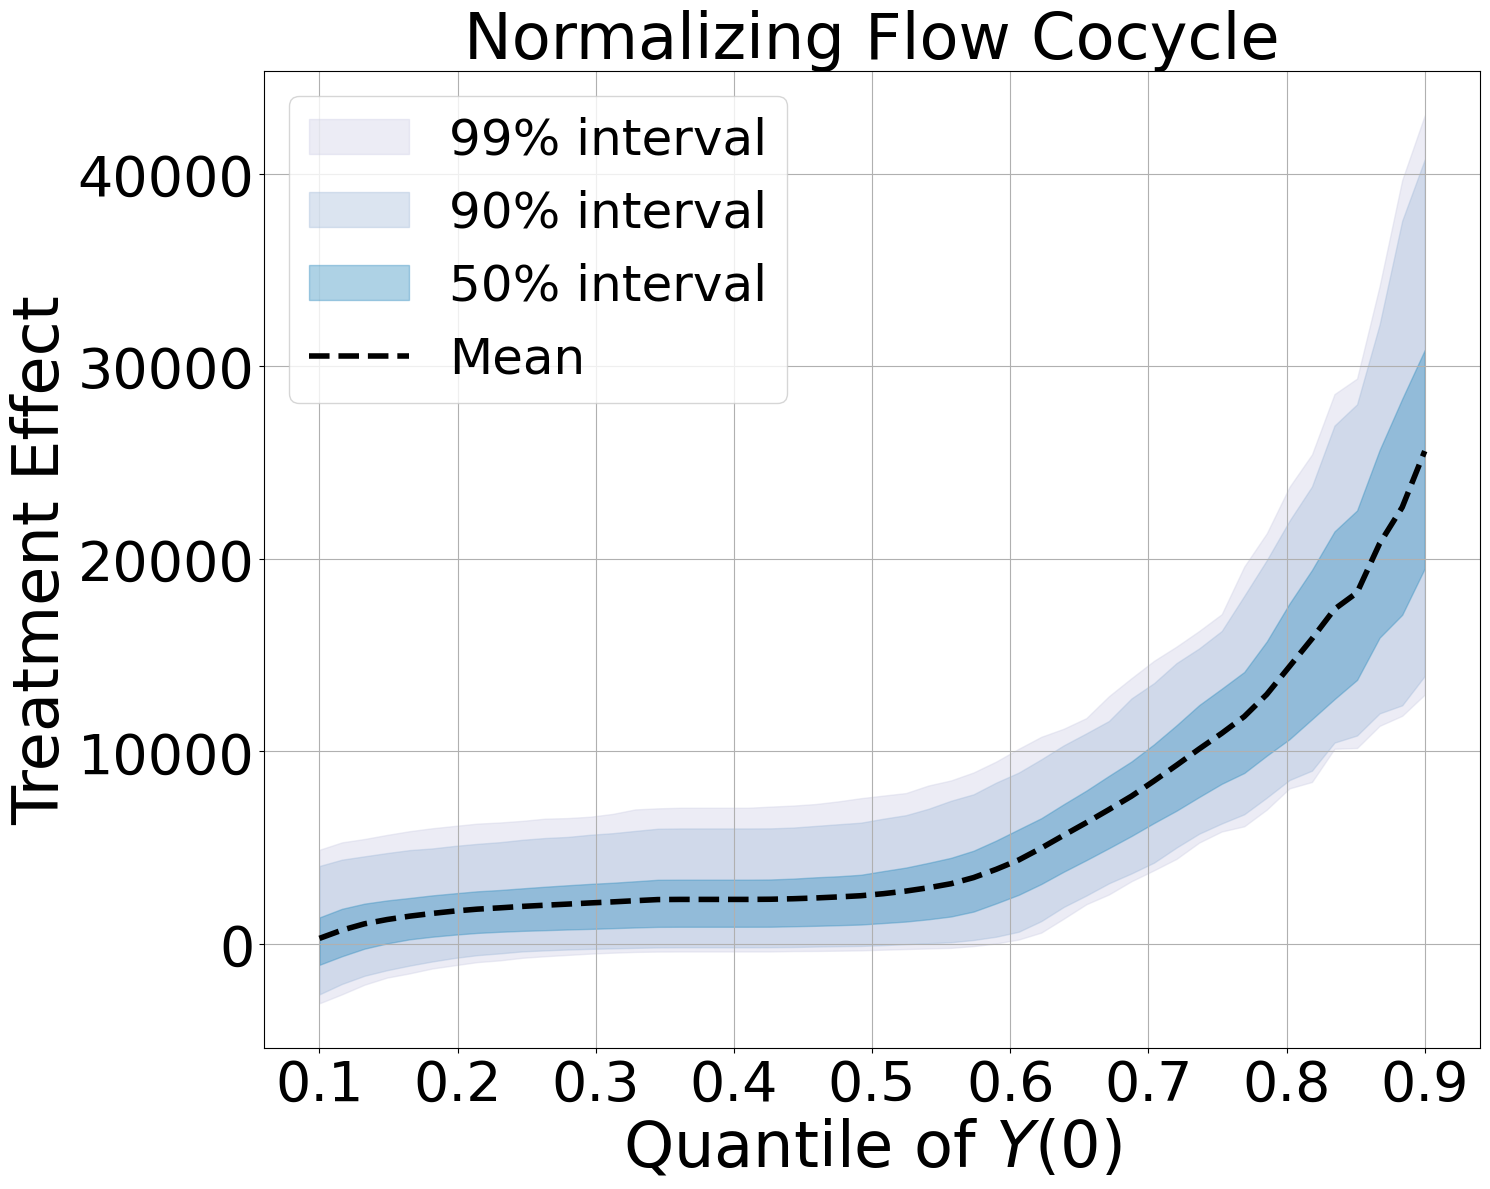

In [88]:
import matplotlib.pyplot as plt

# Set up axis labels
x = torch.linspace(0.1, 0.9, ntest, dtype=torch.float64).numpy()
q = quantile_preds.detach().numpy()  # shape: (n_q, ntest)

# Define quantile levels for shaded regions
quantile_levels = [0.005, 0.05, 0.25, 0.5, 0.75, 0.95, 0.995]
qmap = {level: q[i] for i, level in enumerate(quantile_levels)}

# Create figure with doubled size
plt.figure(figsize=(15, 12))

# Fill between symmetric quantiles
fill_pairs = [(0.005, 0.995), (0.05, 0.95), (0.25, 0.75)]
colors = ['#d0d1e6', '#a6bddb', '#3690c0']  # lighter to darker

for (lo, hi), color in zip(fill_pairs, colors):
    plt.fill_between(x, qmap[lo]*scale_Y.item(), qmap[hi]*scale_Y.item(), alpha=0.4, color=color,
                     label=f'{int((hi - lo)*100+0.1)}% interval')

# Add the median quantile curve
plt.plot(x, mu_preds.detach()*scale_Y, color='black', lw=4.0, label='Mean', ls="dashed")

# Final formatting
plt.xlabel(r'Quantile of $Y(0)$', fontsize=46)
plt.ylabel('Treatment Effect', fontsize=46)
plt.title(r'Normalizing Flow Cocycle', fontsize=46)
plt.legend(fontsize=36, loc = 'upper left')
plt.grid(True)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.tight_layout()
plt.savefig("e401k_nfcocycle.png", bbox_inches = "tight")
plt.show()


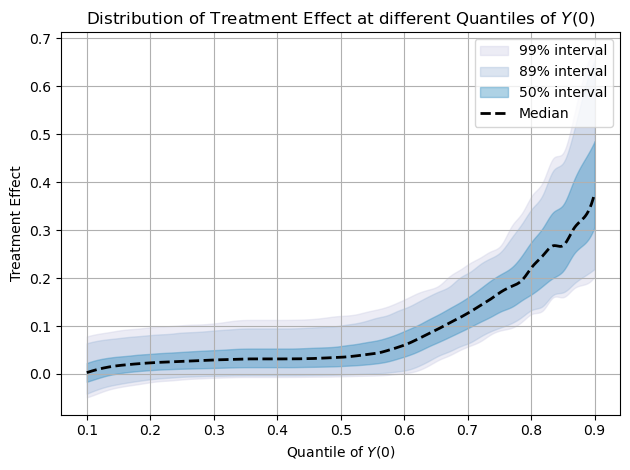

In [66]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.interpolate import make_interp_spline

# Set up axis labels
x = torch.linspace(0.1, 0.9, ntest, dtype=torch.float64).numpy()
q = quantile_preds.detach().numpy()  # shape: (n_q, ntest)

# Define quantile levels for shaded regions
quantile_levels = [0.005, 0.05, 0.25, 0.5, 0.75, 0.95, 0.995]
qmap = {level: q[i] for i, level in enumerate(quantile_levels)}

# Spline-smooth everything
x_smooth = np.linspace(x.min(), x.max(), 1000)
qmap_smooth = {}
for level in quantile_levels:
    spline = make_interp_spline(x, qmap[level], k=3)  # cubic spline
    qmap_smooth[level] = spline(x_smooth)

# Fill between symmetric quantiles
fill_pairs = [(0.005, 0.995), (0.05, 0.95), (0.25, 0.75)]
colors = ['#d0d1e6', '#a6bddb', '#3690c0']  # lighter to darker

for (lo, hi), color in zip(fill_pairs, colors):
    plt.fill_between(x_smooth, qmap_smooth[lo], qmap_smooth[hi],
                     alpha=0.4, color=color,
                     label=f'{int((hi - lo)*100)}% interval')

# Add the median quantile curve
plt.plot(x_smooth, qmap_smooth[0.5], color='black', lw=2.0,
         label='Median', ls="dashed")

# Final formatting
plt.xlabel(r'Quantile of $Y(0)$')
plt.ylabel('Treatment Effect')
plt.title(r'Distribution of Treatment Effect at different Quantiles of $Y(0)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
def cmmd_embedding_loss(model, X, Y, kernel, batchsize=10):
    """
    Computes the CMMD loss correctly via kernel trick:
      CMMD = (1/n) * sum_i || psi(Y_i) - (1/n) sum_j psi(T_{X_i,X_j}(Y_j)) ||^2
    without forming psi explicitly.

    Args:
        model: must have .cocycle(X_i, X_j, Y_j)
        X: (n, d)
        Y: (n, p)
        kernel: kernel object with get_gram(Y1, Y2)
        batchsize: number of outer-loop samples (i) to process

    Returns:
        scalar CMMD loss (torch tensor)
    """
    n = X.shape[0]
    device = X.device
    total_loss = 0.0

    for i_start in range(0, n, batchsize):
        i_end = min(i_start + batchsize, n)
        b = i_end - i_start

        # Get batch of X_i and Y_i
        X_i = X[i_start:i_end]       # (b, d)
        Y_i = Y[i_start:i_end]       # (b, p)

        # Repeat X_i n times to match (i, j)
        X_i_repeat = X_i.unsqueeze(1).repeat(1, n, 1).reshape(b * n, -1)  # (b*n, d)
        X_j = X.repeat(b, 1)                                            # (b*n, d)
        Y_j = Y.repeat(b, 1)                                            # (b*n, p)

        # Apply transport: T_{X_i, X_j}(Y_j)
        Y_hat = model.cocycle(X_i_repeat, X_j, Y_j)  # (b*n, p)
        Y_hat = Y_hat.view(b, n, -1)  # (b, n, p)

        # --- Compute CMMD terms via kernel trick ---

        # Term 1: k(Y_i, Y_i)
        K_yy_diag = torch.diagonal(kernel.get_gram(Y_i, Y_i))  # (b,)

        # Term 2: (1/n^2) sum_{j,j'} k(Ŷ_{ij}, Ŷ_{ij'})
        K_hat_hat = torch.stack([
            kernel.get_gram(Y_hat[i], Y_hat[i]).mean()
            for i in range(b)
        ])  # (b,)

        # Term 3: (1/n) sum_j k(Y_i, Ŷ_{ij})
        K_y_hat = torch.stack([
            kernel.get_gram(Y_i[i:i+1], Y_hat[i]).mean()
            for i in range(b)
        ])  # (b,)

        # Combine terms
        loss_batch = K_yy_diag + K_hat_hat - 2 * K_y_hat
        total_loss += loss_batch.sum()

    return total_loss / n

def cmmd_embedding_loss_optimized(model, X, Y, kernel, batchsize=10):
    """
    Computes CMMD loss:
        CMMD = (1/n) sum_i || ψ(Y_i) - (1/n) sum_j ψ(T_{x_i, x_j}(Y_j)) ||^2

    where T_{x_i, x_j}(Y_j) = f_{x_i} ( f_{x_j}^{-1}(Y_j) )

    Args:
        model: has .inverse_transformation(Y, X), .transformation(Y, X), .conditioner(X)
        X: (n, d)
        Y: (n, p)
        kernel: with .get_gram(A, B)
        batchsize: number of i's per batch

    Returns:
        scalar torch.Tensor
    """
    import gc, psutil, os

    n = X.shape[0]
    device = X.device
    total_loss = 0.0

    # ✅ Precompute base samples: f^{-1}_{x_j}(Y_j)
    print("Precomputing inverse-transformed base samples...")
    with torch.no_grad():
        Z_base = model.inverse_transformation(X, Y).detach()  # (n, p)

    for i_start in range(0, n, batchsize):
        i_end = min(i_start + batchsize, n)
        b = i_end - i_start

        X_i = X[i_start:i_end]     # (b, d)
        Y_i = Y[i_start:i_end]     # (b, p)
        loss_batch = torch.zeros(b, device=device)

        for i in range(b):
            xi = X_i[i:i+1]        # (1, d)
            yi = Y_i[i:i+1]        # (1, p)

            # Compute transported samples: T_{xi, xj}(Y_j) = f_{xi}(Z_base)
            xi_repeat = xi.repeat(n, 1)  # (n, d)
            with torch.no_grad():
                Y_hat = model.transformation(xi_repeat,Z_base).detach().unsqueeze(-1)  # (n, p)
            # Compute kernel terms
            k_yy = kernel.get_gram(yi, yi).item()
            k_hat_hat = kernel.get_gram(Y_hat, Y_hat).mean().item()
            k_y_hat = kernel.get_gram(yi, Y_hat).mean().item()

            loss_i = k_yy + k_hat_hat - 2 * k_y_hat
            loss_batch[i] = loss_i

        total_loss += loss_batch.sum()

        mem_MB = psutil.Process(os.getpid()).memory_info().rss / 1e6
        print(f"[{i_end}/{n}] Memory used (MB): {mem_MB:.2f}")
        gc.collect()
        torch.cuda.empty_cache()

    return total_loss / n

def cmmd_embedding_loss_vectorized(model, X, Y, kernel, batchsize=10):
    """
    Fully vectorized CMMD loss with batch processing over i.

    Args:
        model: with .inverse_transformation(X, Y), .transformation(X, Z)
        X: (n, d)
        Y: (n, p)
        kernel: with get_gram(A, B)
        batchsize: outer batch size

    Returns:
        scalar CMMD loss
    """
    import torch, gc, psutil, os

    n = X.shape[0]
    device = X.device
    total_loss = 0.0

    # Step 1: precompute base latent samples Z = f^{-1}_{x_j}(Y_j)
    print("Precomputing inverse-transformed base samples...")
    with torch.no_grad():
        Z_base = model.inverse_transformation(X, Y).detach()  # shape: (n, p)

    for i_start in range(0, n, batchsize):
        i_end = min(i_start + batchsize, n)
        b = i_end - i_start

        X_i = X[i_start:i_end]      # shape: (b, d)
        Y_i = Y[i_start:i_end]      # shape: (b, p)

        # Step 2: expand X_i to match (b x n) for transformation
        X_i_repeat = X_i[:, None, :].repeat(1, n, 1).reshape(b * n, -1)   # (b*n, d)
        Z_repeat = Z_base[None, :, :].repeat(b, 1, 1).reshape(b * n, -1)  # (b*n, p)

        # Step 3: transform → Y_hat[i, j, :] = f_{x_i}(Z_j)
        with torch.no_grad():
            Y_hat = model.transformation(X_i_repeat, Z_repeat).detach().reshape(b, n, -1)  # (b, n, p)

        # Step 4: Compute CMMD loss terms vectorized
        k_yy_diag = torch.diagonal(kernel.get_gram(Y_i, Y_i))  # (b,)
        k_y_hat = torch.stack([
            kernel.get_gram(Y_i[i:i+1], Y_hat[i]).mean()
            for i in range(b)
        ])
        k_hat_hat = torch.stack([
            kernel.get_gram(Y_hat[i], Y_hat[i]).mean()
            for i in range(b)
        ])

        loss_batch = k_yy_diag + k_hat_hat - 2 * k_y_hat
        total_loss += loss_batch.sum()

        mem_MB = psutil.Process(os.getpid()).memory_info().rss / 1e6
        print(f"[{i_end}/{n}] Memory used (MB): {mem_MB:.2f}")
        gc.collect()
        torch.cuda.empty_cache()

    return total_loss / n

In [47]:
val_start = int(0.8*N)
Xval,Yval = Xtr[val_start:], Ytr[val_start:]
cmmd_embedding_loss(final_model_overall,Xval,Yval,loss.kernel[-1])

tensor(0.4589, grad_fn=<DivBackward0>)